In [1]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying :class:`~sklearn.decomposition.NMF` and
:class:`~sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a plot of topics, each represented as bar plot
using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).


In [2]:
from time import time
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies

print("Loading dataset...")
t0 = time()
bunch = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
)

data_samples = bunch.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 0.786s.


In [3]:
data_samples
data_samples[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [4]:
bunch.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
labels_samples = bunch.target[:n_samples]
labels_samples

array([17,  0, 17, ...,  3, 15,  9])

## Understanding vectorization

Following tutorial from https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [6]:
# playing with countvector
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [7]:
corpus = [
     'This is the first document.',
     'This is the second second document.',
     'And the third one.',
     'Is this the first document?',
]

X = vectorizer.fit_transform(corpus)
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [8]:
# the vectorizer has tokenized all the words (vocabullary)

# this will show the actual names
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [9]:
# the X represents presence of each word in each document
# We passed 4 documents, therefore X has 4 rows
# each row contains 9 elements because there are 9 total words
# the value 0,1,2 show the count of number of times that word is present in that document
X.toarray()

# in first document:
# and is present 0 times, document is present 1 time, first is present 1 time

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [10]:
# we created a vocabulary of individual words in the above
# it ignored relative positions of the words
#
# we can create a vocabulary of phrases as well by using n_grams
# for example, an n_gram of 2 will create a dictionary of all
# individual words as well as all 2 consecutive words

In [11]:
# we didn't use stop words in the above

### Understanding tf-idf

Based on readings and examples from https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [12]:
# we used the above vectorisation strategy to convert a raw text
# into a matrix of numbers
# each row in the matrix represents the document row.
#
# each row has equal number of elements
# the number of elements is the dictionary of all words
# the number in each row represents the count of number of times the dictionary word is used in document
#
# now we can use this matrix of numbers (bag-of-words) to do further analysis
#
# tf-idf is a method to give weighted information for each term in each document
# we use tfidf-transformer to convert the count matrix into weight matrix
#
# this transformation from count matrix -> to weighted matrix is done using formula:
# term weight = term-frequency * 1 / uniqueness of term
# i.e. terms-weight is directly proportional to its frequency
# but inversely proportional to how frequently it is found in OTHER documents
# this final term-weight is a value between 0 to 1.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
transformer

TfidfTransformer()

In [14]:
# convert X bag-of-words into weighted average
tfidf = transformer.fit_transform(X)
tfidf.toarray()

array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.27230147, 0.        , 0.27230147, 0.        ,
        0.85322574, 0.22262429, 0.        , 0.27230147],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(corpus)
X.toarray()

array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.27230147, 0.        , 0.27230147, 0.        ,
        0.85322574, 0.22262429, 0.        , 0.27230147],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

In [17]:
tfidf_vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [18]:
# reduce number of features (dimensions) using SVD (latent semantic analysis)

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print(
    "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
)

print('samples, features =', X.shape)

done in 0.006194s
Explained variance of the SVD step: 64%
samples, features = (4, 2)


In [19]:
X

array([[ 0.99733498, -0.07295848],
       [ 0.99457648, -0.10400781],
       [ 0.18342269,  0.98303414],
       [ 0.99733498, -0.07295848]])

## Trying topic extraction on announcements

Generating dump

```python
from announcements.models import BseAnnouncement
import datetime as dt

announcements = (
    BseAnnouncement.objects.filter(date__gt=dt.date.today() - dt.timedelta(days=365))
    .values('company_code__name', 'date', 'subject', 'headline', 'more', 'category')
)
print(len(announcements))

import json
from django.core.serializers.json import DjangoJSONEncoder
qs_json = json.dumps(list(announcements), indent=4, sort_keys=True, cls=DjangoJSONEncoder)

with open('/home/ubuntu/anns.json', 'w') as f:
    f.write(qs_json)
```

In [21]:
import json
import gzip

with gzip.open('anns.json.gz') as f: 
    announcements = json.load(f)
announcements[:3]

[{'category': 'Corp. Action',
  'company_code__name': 'Allcargo Logistics Ltd',
  'date': '2021-03-16T07:31:56',
  'headline': 'Allcargo Logistics Ltd has informed BSE that the Directors at their Board Meeting held on March 15, 2021, inter alia, approved and declared an Interim Dividend of Rs. 2/- (100%) per equity share of face value of Rs. 2/- each for the financial year 2020-2021. The Interim Dividend will be paid/dispatched to all equity shareholders of the Company on or after March 24, 2021.',
  'more': '',
  'subject': 'Board declares Interim Dividend'},
 {'category': 'Corp. Action',
  'company_code__name': 'Infosys Ltd',
  'date': '2021-03-16T07:29:22',
  'headline': 'Infosys Ltd has informed BSE that a meeting of the Board of Directors of the Company will be held on April 13 & 14, 2021, inter alia to:<BR><BR>1. Approval and take on record the audited consolidated financial results of the Company and its subsidiaries as per Indian Accounting Standards (INDAS) for the quarter and

In [22]:
def _get_ann_content(ann):
    headline = ann['headline'] if len(ann['headline']) > len(ann['more']) else ann['more']
    return f"{ann['subject']}\n\n{headline}"

data_raw = [_get_ann_content(ann) for ann in announcements]
data_raw[:3]

['Board declares Interim Dividend\n\nAllcargo Logistics Ltd has informed BSE that the Directors at their Board Meeting held on March 15, 2021, inter alia, approved and declared an Interim Dividend of Rs. 2/- (100%) per equity share of face value of Rs. 2/- each for the financial year 2020-2021. The Interim Dividend will be paid/dispatched to all equity shareholders of the Company on or after March 24, 2021.',
 'Board to consider FY21 results & Final Dividend on April 13 & 14, 2021\n\nInfosys Ltd has informed BSE that a meeting of the Board of Directors of the Company will be held on April 13 & 14, 2021, inter alia to:<BR><BR>1. Approval and take on record the audited consolidated financial results of the Company and its subsidiaries as per Indian Accounting Standards (INDAS) for the quarter and year ending March 31, 2021.<BR><BR>2. Approve and take on record the audited standalone financial results of the Company as per INDAS for the quarter and year ending March 31, 2021.<BR><BR>3. Ap

In [25]:
import lxml.html
import re

replacements = {
    # lodr
    'listing obligations and disclosure requirements': 'lodr',
    '(lodr)': 'lodr',
    'regulations, 2015': 'regulations 2015',
    'sebi lodr regulations 2015': 'lodr',
    'regulation 30': '',
    # sebi
    'Securities And Exchange Board Of India': 'sebi',
    'Substantial Acquisition of Shares & Takeovers': 'sast',
    'Insider Trading Prohibition Code': 'itpc',
    # egm
    'Extra - Ordinary': 'extra ordinary',
    'extra ordinary': 'extraordinary',
    'extraordinary general meeting': 'egm',
    'annual general meeting': 'agm',
}

re_replacements = {re.compile(re.escape(k), re.IGNORECASE): v for k,v in replacements.items()}

def _clean_doc(text):
    if not text:
        return ''

    # remove html tags
    text = lxml.html.fromstring(text).text_content()

    # handle abbreviations
    for phrase, replacement in re_replacements.items():
        text = phrase.sub(replacement, text)
    return text

In [26]:
t0 = time()
data_clean = [_clean_doc(row) for row in data_raw]
print('time taken %fs' % (time() - t0))

data = data_clean
data[:3]

time taken 14.263225s


['Board declares Interim Dividend\n\nAllcargo Logistics Ltd has informed BSE that the Directors at their Board Meeting held on March 15, 2021, inter alia, approved and declared an Interim Dividend of Rs. 2/- (100%) per equity share of face value of Rs. 2/- each for the financial year 2020-2021. The Interim Dividend will be paid/dispatched to all equity shareholders of the Company on or after March 24, 2021.',
 'Board to consider FY21 results & Final Dividend on April 13 & 14, 2021\n\nInfosys Ltd has informed BSE that a meeting of the Board of Directors of the Company will be held on April 13 & 14, 2021, inter alia to:1. Approval and take on record the audited consolidated financial results of the Company and its subsidiaries as per Indian Accounting Standards (INDAS) for the quarter and year ending March 31, 2021.2. Approve and take on record the audited standalone financial results of the Company as per INDAS for the quarter and year ending March 31, 2021.3. Approve and take on record

## Define some good defaults

In [27]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

## Find most common phrases

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

t0 = time()
count_vectorizer = CountVectorizer(max_df=.5, min_df=50, ngram_range=(2, 3), stop_words=stop_words)
X = count_vectorizer.fit_transform(data)

print('time taken %fs' % (time() - t0))

time taken 13.065678s


In [25]:
print('shape', X.shape)

shape (288726, 29421)


In [26]:
count_phrases = X.sum(axis=0)
count_phrases

matrix([[ 598,  511, 1664, ...,  153,  153,   51]])

In [27]:
phrase_freq = [(phrase, count_phrases[0, idx]) for phrase, idx in count_vectorizer.vocabulary_.items()]

In [28]:
phrase_freq = sorted(phrase_freq, key = lambda x: x[1], reverse=True)
phrase_freq

[('financial results', 102288),
 ('investor complaints', 87599),
 ('board meeting', 78280),
 ('year ended', 70470),
 ('quarter ended', 67731),
 ('board directors', 63220),
 ('announcement lodr', 57404),
 ('quarter investor', 52506),
 ('quarter investor complaints', 52505),
 ('31 2021', 51692),
 ('regulations 2015', 50252),
 ('30 2021', 46183),
 ('directors company', 45711),
 ('board directors company', 44973),
 ('trading window', 40578),
 ('audited financial', 39911),
 ('period ended', 39680),
 ('meeting board', 39415),
 ('september 2021', 39140),
 ('results quarter', 38851),
 ('inter alia', 38697),
 ('ended 31st', 38636),
 ('meeting board directors', 37933),
 ('half year', 37369),
 ('financial results quarter', 37053),
 ('audited financial results', 36608),
 ('march 2021', 35565),
 ('pursuant regulation', 35253),
 ('half year ended', 34954),
 ('meeting held', 34914),
 ('ended march', 34010),
 ('consider approve', 31874),
 ('unaudited financial', 31650),
 ('please find', 31518),
 ('mar

In [29]:
def _print_samples(data, phrase):
    phrase = phrase.lower()
    print([row for row in data if phrase in row.lower()][:3])
    
_print_samples(data[:10000], 'general meeting')

["Update on board meeting\n\nVIKAS WSP LTD.has informed BSE that the meeting of the Board of Directors of the Company is scheduled on 18/03/2021 ,inter alia, to consider and approve This is inform you that pursuant to Regulation 29 of the sebi (Listing Obligations and Disclosure Requirement) regulations 2015 ('Listing Regulations'), a meeting of the Board of Directors of the Company is scheduled to be held on Thursday , March  18, 2021 at B-86/87, RIICO, Udyog Vihar, Industrial Area, Sri Ganga nagar-335002 at 11.00 A.M., inter-alia, to consider following items:  1. Consider Appointment of M/s AK Chadda & Co., Chartered Accountants as Statutory Auditor of the Company to fill casual vacancy caused due to resignation of Statutory Auditors M/s S. Prakash Aggarwal & Co., Chartered Accountants., subject to the approval of Shareholders in the ensuing General Meeting.  2. Any other matters with permission of board.  If approved and considered by the Board an EGM/Postal Ballot would be called. 

## Analyse categories

In [28]:
# group announcements by categories
categories = {}

for doc in announcements:
    category = doc['category']
    if category not in categories:
        categories[category] = []
    categories[category].append(doc)

for category, docs in categories.items():
    print(category, len(docs))

Corp. Action 7334
Insider Trading / SAST 27155
Company Update 151678
Board Meeting 27233
 21180
Result 29135
AGM/EGM 23790
 Corp Action 1040
New Listing 85
Corp Action 262


In [29]:
self_explanatory_categories = [
    'Insider Trading / SAST',
    'Result',
    'New Listing',
]

categories_with_own_clusters = [
    'Corp. Action',
    ' Corp Action',
    'Corp Action',
    'AGM/EGM',
    'Board Meeting',
    
]

other_categories = [
    c for c in categories
    if c not in (self_explanatory_categories + categories_with_own_clusters)
]

other_categories

['Company Update', '']

## Creating clusters for wide categories

Categories like `corp-action`, `agm-egm`, `board-meeting` are good, but little wide.

Let's see if we can extract more details for them.

In [33]:
from collections import Counter

def _describe_counter(counter, texts, param):
    unique_count = len([k for k, v in counter.items() if v == 1])
    bundles_count = len(texts) - unique_count

    print('Total docs:', len(texts))
    print('\n')
    print(f'{bundles_count} bundles:\n', counter.most_common(8))
    print('\n')
    print(f'{unique_count} unique:\n', counter.most_common()[-4:])
    
def describe(docs, param):
    texts = [doc[param] for doc in docs]

    # show different kinds of values
    counter = Counter()
    for text in texts:
        counter[text] += 1

    _describe_counter(counter, texts, param)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer


def cluster_on_idf(docs, param):
    texts = [doc[param] for doc in docs]
    
    # create tf-idf for texts
    text_transformer = TfidfVectorizer(max_df=.6, min_df=50, stop_words=stop_words)
    X = text_transformer.fit_transform(texts)
    
    # group by most common word
    counter = Counter()
    x = X.toarray()
    names = text_transformer.get_feature_names_out()
    for row in x:
        name_vals = sorted(zip(row, names), reverse=True)
        most_used = name_vals[0][1]
        counter[most_used] += 1
    _describe_counter(counter, texts, param)

In [205]:
describe(categories['Corp. Action'], 'subject')

Total docs: 151678


126829 bundles:
 [('Announcement under Regulation 30 (LODR)-Newspaper Publication', 17369), ('Compliances-Certificate under Reg. 74 (5) of SEBI (DP) Regulations, 2018', 14698), ('Announcement under Regulation 30 (LODR)-Analyst / Investor Meet - Intimation', 9633), ('Announcement under Regulation 30 (LODR)-Press Release / Media Release', 5562), ('Statement Of Investor Complaints For The Quarter Ended December 2021', 4274), ('Shareholding for the Period Ended March 31, 2021', 4273), ('Shareholding for the Period Ended September 30, 2021', 4271), ('Statement Of Investor Complaints For The Quarter Ended September 2021', 4268)]


24849 unique:
 [('Clarification sought from Lancor Holdings Ltd', 1), ('Clarification sought from Ion Exchange India Ltd', 1), ('Clarification sought from Navkar Urbanstructure Ltd', 1), ('Petition Before Delhi High Court By Amazon', 1)]


In [84]:
cluster_on_idf(categories['Corp. Action'], 'subject')

Total docs: 7334


7329 bundles:
 [('approves', 642), ('consider', 620), ('recommends', 435), ('interim', 309), ('fixes', 289), ('annual', 210), ('purpose', 202), ('bonus', 170)]


5 unique:
 [('meeting', 1), ('requirements', 1), ('year', 1), ('division', 1)]


In [200]:
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import csv


def _get_kmeans_cluster(X, n_clusters):    
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    return kmeans


def _get_silhouette_score(X, kmeans):
    score = silhouette_score(X, kmeans.labels_)
    remark = 'bad' if score < .4 else (
        'okay' if score < .6 else 'good'
    )
    return score, remark


def _plot_silhouette_score_graph(X, n_clusters):
    n__score = {}
    samples = sorted(
        set(round(i) for i in np.linspace(n_clusters * .8, n_clusters * 1.2, 4))
    )
    for i in samples:
        kmeans = _get_kmeans_cluster(X, i)
        score, _ = _get_silhouette_score(X, kmeans)
        n__score[i] = score
    
    # print the above values
    x_axis = list(n__score.keys())
    y_axis = list(n__score.values())
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.plot(x_axis, y_axis)
        

def _preview_clusters(clusters):
    # print first 2 and last 2 items of each cluster
    for label, items in clusters.items():
        by_score = sorted(items, key=lambda o: o[1])
        print('\n', 'label:', label, '\n', by_score[:2], by_score[-2:], '\n')
    

def _generate_csv(clusters, param, filename):
    headings = [param, 'label', 'score', 'tag']
    
    rows = []
    for label, items in clusters.items():
        for text, score in items:
            row = [text, label, score, '']
            rows.append(row)

    with open(filename, 'x') as f:
        writer = csv.writer(f)
        writer.writerow(headings)
        writer.writerows(rows)
    

def cluster_by_kmeans(docs, param, n_clusters=8, detailed_output=True):
    texts = [doc[param] for doc in docs]
    
    # create tf-idf for texts
    text_transformer = TfidfVectorizer(max_df=.6, min_df=50, stop_words=stop_words)
    X = text_transformer.fit_transform(texts)
    
    # reduce features using linear semantic analysis (SVD)
    svd = TruncatedSVD(n_components=100)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    print(X.shape)

    kmeans = _get_kmeans_cluster(X, n_clusters=n_clusters)
    score, remark = _get_silhouette_score(X, kmeans)
    print('silhouette score', score, remark)

    if not detailed_output:
        return
    doc_distances = kmeans.transform(X)
    clusters = defaultdict(list)
    for idx, doc_distance in enumerate(doc_distances):
        text = texts[idx]
        doc_distance = list(doc_distance)
        score = min(doc_distance)
        label = list(doc_distance).index(score)
        clusters[label].append((text, score))

    counter = Counter(**{str(label): len(items) for label, items in clusters.items()})
    _describe_counter(counter, texts, param)    
    
    _plot_silhouette_score_graph(X, n_clusters)
    _preview_clusters(clusters)
    return clusters

In [201]:
n_clusters = 200
param = 'subject'
category = 'Corp. Action'
cluster_by_kmeans(categories[category], param, n_clusters=n_clusters, detailed_output=False)

(7334, 100)
silhouette score 0.5437487883608789 okay


(7334, 100)
silhouette score 0.5484636004942447 okay
Total docs: 7334


7334 bundles:
 [('2', 642), ('3', 346), ('22', 280), ('26', 239), ('5', 196), ('9', 158), ('0', 152), ('17', 145)]


0 unique:
 [('66', 5), ('163', 5), ('148', 4), ('56', 3)]

 label: 17 
 [('Board declares Interim Dividend', 0.015350701295243067), ('Board declares Interim Dividend', 0.015350701295243067)] [('Board declares lnterim Dividend', 0.5084883557756182), ('Board declares Inteirm Dividend', 0.5084883557756182)] 


 label: 61 
 [('Board to consider FY21 results & Dividend on April 15, 2021', 0.2545599010535641), ('Board to consider FY21 results & Dividend on April 20, 2021', 0.2545599010535641)] [('Board to consider FY21 results & Final Dividend on April 28, 29 & 30, 2021', 0.5684286173798856), ('Board to consider Q1 results & Interim Dividend on April 19, 2021', 0.578107684632585)] 


 label: 0 
 [('Fixes Record Date for Interim Dividend', 0.012693139290588913), ('Fixes Record Date for Interim Dividend', 0.

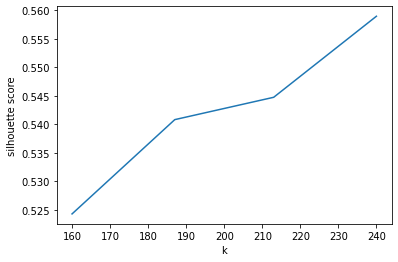

In [202]:
clusters = cluster_by_kmeans(categories[category], param, n_clusters=n_clusters, detailed_output=True)

In [204]:
filename = category + '.csv'
_generate_csv(clusters, param, filename)

import webbrowser
webbrowser.open(filename)

FileExistsError: [Errno 17] File exists: 'Corp. Action.csv'

## Analyse subjects

The subjects contain highly accurate information. We can use them to create wider categories.

Only few subjects are prone to bad-headings. These are subjects like: lodr, media release, newspaper print. For these we can define new categories.

Let's analyse subects first.

In [111]:
from collections import Counter

subjects = [doc['subject'] for doc in announcements]

# see different kinds of subjects and counts
counter = Counter()
for subject in subjects:
    counter[subject] += 1

print(counter.most_common(3))

[('Announcement under Regulation 30 (LODR)-Newspaper Publication', 17363), ('Closure of Trading Window', 15958), ('Compliances-Certificate under Reg. 74 (5) of SEBI (DP) Regulations, 2018', 14698)]


## Define our own labels

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()

headline_transformer = TfidfVectorizer(max_df=.5, min_df=50, stop_words=stop_words)
headlines = [_clean_doc(_get_headline(doc)) for doc in announcements]
X = headline_transformer.fit_transform(headlines)

print('time taken %fs' % (time() - t0))
X.shape

time taken 17.328874s


(288726, 4016)

In [102]:
from collections import Counter

UNKNOWN = "unknown"

def _print_important_words(headline):
    row = headline_transformer.transform([headline])
    names = headline_transformer.get_feature_names_out()
    row = row.toarray()[0]
    name_vals = sorted(zip(row, names), reverse=True)
    print(name_vals[:8])

def _case_insensitive_dict(d):
    return {k.lower(): v.lower() for k, v in d.items()}

def _get_headline(doc):
    return (
        doc["headline"]
        if len(doc['headline']) > len(doc['more'])
        else doc["more"]
    )

def _reset_labels(docs):
    for doc in docs:
        doc['label'] = UNKNOWN

def _set_label(doc, label):
    is_already_set = (doc['label'] != UNKNOWN) and (label != doc['label'])
    if is_already_set:
        raise ValueError('Document already has label', doc['label'], doc['subject'])
    
    doc['label'] = label


def _set_labels(docs):
    for doc in docs:
        subject = doc["subject"].casefold()
        headline = _get_headline(doc).casefold()

        if "label" not in doc:
            doc["label"] = UNKNOWN

        for ph_sub, label in subject__labels.items():
            if ph_sub in subject:
                _set_label(doc, label)

        for ph_headline, label in headline__labels.items():
            if ph_headline in headline:
                _set_label(doc, label)

        for ph, label in any__labels.items():
            if (ph in subject) or (ph in headline):
                _set_label(doc, label)

def _print_stats(docs):
    counter = Counter()
    for doc in docs:
        counter[doc['label']] += 1
    print("\n\n\n", counter)

def _print_first_unknown(docs):
    for doc in docs:
        if doc['label'] == UNKNOWN:
            headline = _get_headline(doc)
            print(doc['subject'], "\n\n", headline)
            _print_important_words(headline)
            return

# labels
subject__labels = _case_insensitive_dict({
    "details of loss of certificate": "duplicate_certificate",
    "duplicate certificate": "duplicate_certificate",
    "investor meet": "investor meet",
    "general disclosure under the securities": "general disclosure",
    "(LODR)-Acquisition": "acquisition",
    "proceedings of postal ballot": "meeting results",
    "scrutinizer''s report": "meeting results",
    "voting results": "meeting results",
    "strikes /lockouts / disturbances": "strike",
    "Rectifying The Above Typographical Error": "revision",
    "revised result": "revised result",
    "SAST": "sast",
    "Becomes 3Rd Largest": "appreciation",
    "Gas Discovery": "gas discovery",
    "Scheme of Arrangement": "scheme of arrangement",
#     "Closure of Trading Window": "trading window",
    "demise": "demise",
    "Consider Dividend": "bm consider dividend",
})
headline__labels = _case_insensitive_dict({
    "conversion of the warrants": "warrant conversion",
    "commenced commercial production": "commercial production",
#     "start Commercial operations": "commercial production",
    "discovers gas": "gas discovery",
    "Company has no information": "no information",
    "awarded the order": "order update",
    "receives USFDA approval": "usfda approval",
    "launch its new": "new product",
    "amalgamation update": "amalgamation update",
})
any__labels = _case_insensitive_dict({
    
})
        
# take first n docs
docs = announcements[:10000]
_reset_labels(docs)
_set_labels(docs)
_print_first_unknown(docs)
_print_stats(docs)

Grant Of Permission To Establish Oils And Oleoresin Essential Oils Plant Of Capacity - 600 Kilo Liters Per Year At Agro Division.  

  This is to inform you that the Chhattisgarh Environment Conservation Board, vide its letters dated 20.01.2021 has granted its consent to the Company, to establish Oils and Oleoresin Essential Oils Plant of capacity - 600 Kilo Liters Per Year within existing Agro plant premises at Khasra No. 150, 151/1, 151/4 & 151/5, Urla Guma Road, Village - Borjhara, District - Raipur (C.G.) under Water (Prevention and Control of Pollution) Act, 1974 and Air (Prevention and Control of Pollution) Act 1981. These facilities are presently under commissioning and the Company expects to start Commercial operations in these facilities as quickly as possible after grant of permission to operate.<BR> <BR> Currently, the Company is engaged in the business of Iron, Steel and Ready to eat frozen foods. Now the management has decided to diversify its boundary. As a part of the st

## Extract clusters

In [190]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pratyush/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [191]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

stemmer = WordNetLemmatizer()

@lru_cache(maxsize=1024)
def _get_stem(word):
    return stemmer.lemmatize(word)

class LemmaTokenizer:

    def __call__(self, doc):
        return [
            _get_stem(t)
            for t in wordpunct_tokenize(doc)
            if t not in stop_words
        ]

t0 = time()
vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=50,
        use_idf=True,
        tokenizer=LemmaTokenizer(),
    )
X = vectorizer.fit_transform(data)

print("done in %fs" % (time() - t0))
print("samples, features =", X.shape)

done in 28.805475s
samples, features = (288726, 3954)


In [192]:
print(data[0])
vectorizer.inverse_transform(X[0])

Compliances-Reg. 39 (3) - Details of Loss of Certificate / Duplicate Certificate

Pursuant to Regulation 39(3) of the lodr, we wish to inform you that the Company has received requests for issue of duplicate share certificates in lieu of the old certificates which have been reported lost/misplaced by the shareholders.


[array(['shareholder', 'misplaced', 'lost', 'reported', 'old', 'lieu',
        'share', 'issue', 'request', 'received', 'inform', 'wish', 'lodr',
        'regulation', 'pursuant', 'duplicate', '/', 'certificate', 'loss',
        'detail', ')', '3', '39', 'reg', 'compliance'], dtype='<U31')]

In [193]:
def _inverse_transform_weight(vectorizer, row):
    names = vectorizer.get_feature_names_out()
    row = row.toarray()[0]
    name_vals = sorted(zip(row, names), reverse=True)
    return name_vals[:8]

_inverse_transform_weight(vectorizer, X[0])

[(0.4557245634942922, 'certificate'),
 (0.30723194177184804, 'duplicate'),
 (0.3060136142836076, '39'),
 (0.28995195162473086, 'old'),
 (0.2508382344962418, 'misplaced'),
 (0.23645878488184593, 'lieu'),
 (0.23353188881729645, 'reported'),
 (0.2308140041831322, 'lost')]

In [194]:
print(data[1])
_inverse_transform_weight(vectorizer, X[1])

Announcement under  lodr-Allotment

With reference to above and further to our intimation date 27th February, 2021, this is to inform you that warrant holders (i.e. Promoter Group entities) have exercised their right for conversion of the warrants into equity shares of the Company. Consequently, the Board of Directors of the Company at their meeting held today i.e. on 14th March, 2021 has allotted 1,01,76,923 equity shares of face value of Re. 1/- each (with a premium of Rs. 51/- per equity share) pursuant to exercise of 1,01,76,923 convertible warrants.  These equity shares allotted on conversion of the warrants, shall rank pari passu, in all respects with the existing equity shares.  Post the allotment of equity shares, the paid up equity shares of the Company has increased from INR 27,38,35,000/- (Rupees Twenty Seven Crore Thirty Eight Lakhs Thirty Five Thousand only) to INR 28,40,11,923/- (Rupees Twenty Eight Crore Forty Lakhs Eleven Thousand Nine Hundred and Twenty Three only)  


[(0.3373788532709151, 'equity'),
 (0.33470556160102627, 'warrant'),
 (0.24898365907456949, 'twenty'),
 (0.24503231554560412, 'share'),
 (0.2396079208383139, '/-'),
 (0.20335795959883743, '76'),
 (0.18559315284744632, 'conversion'),
 (0.17533108415528312, 'thirty')]

In [195]:
print(data[2])
_inverse_transform_weight(vectorizer, X[2])

General Disclosure Under The sebi lodr regulations 2015 - 3B Binani Glassfibre SARL

General Disclosure under the sebi lodr regulations 2015 - 3B Binani Glassfibre SARL


[(0.7378048314900639, 'general'),
 (0.3631716328084742, 'disclosure'),
 (0.3510199383339402, '2015'),
 (0.28409910008449857, 'sebi'),
 (0.24710787250664928, 'lodr'),
 (0.24240626914664926, 'regulation'),
 (0.0, '™'),
 (0.0, '”)')]

In [196]:
print(data[3])
_inverse_transform_weight(vectorizer, X[3])

Revised Result For Quarter And Nine Months Ended On 31.12.2020 In Format Asked Through Mail

Dear Sir,  Please find enclosed herewith the revised Results for the quarter and nine months ended on 31.12.2020 as asked by you through mail and proforma approved through mail.  Thanking You with Regards Yours Faithfully  For  Rishab Special Yarns Limited    Managing Director DIN: 00349697


[(0.5481677421225989, 'mail'),
 (0.3057026155019582, 'revised'),
 (0.2503492109973148, 'nine'),
 (0.24483113416651148, 'yarn'),
 (0.239126960716256, 'month'),
 (0.23309085854503653, '12'),
 (0.22828571150957902, '2020'),
 (0.18385685253095252, 'special')]

In [197]:
print(data[4])
_inverse_transform_weight(vectorizer, X[4])

Announcement under  lodr-Acquisition

We wish to inform you that Axis Bank Limited has entered into definitive agreements with Fettle Tone LLP and the other partners of Fettle Tone LLP on 13th March 2021 in connection with Axis Bank Limited's proposed acquisition of 9.90% of the aggregate partnership interest of Fettle Tone LLP pursuant to a contribution by Axis Bank Limited in Fettle Tone LLP's partnership capital.  The details as required under  of the sebi (Listing Obligations & Disclosure Requirements) regulations 2015 are attached. 


[(0.4670645487041499, 'llp'),
 (0.4650074298410163, 'axis'),
 (0.3154553540235189, 'partnership'),
 (0.29135420044096133, 'bank'),
 (0.21526777748755083, 'acquisition'),
 (0.1740387700355057, 'definitive'),
 (0.16145278586894393, 'limited'),
 (0.1590115339222823, 'contribution')]

## Returning to our code

In [33]:
# now data we have a sample data,
# lets convert it to a tf-idf vector

from sklearn.feature_extraction.text import TfidfVectorizer

# exclude common English words
# also exclude words only one document
# or in at least 95% of the documents
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, # ignore words which are present in over 95% documents
    min_df=2, # ignore words which are present in less than 2 documents
    max_features=1000, # consider only the top 1000 words by frequency
    stop_words="english", # ignore common english words such as the
)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.173s.


In [35]:
tfidf_vectorizer.get_feature_names_out()

array(['00', '000', '10', '100', '11', '12', '128', '13', '130', '14',
       '15', '16', '17', '18', '19', '1992', '1993', '20', '200', '21',
       '22', '23', '24', '25', '250', '26', '27', '28', '29', '2nd', '30',
       '300', '31', '32', '33', '34', '35', '36', '37', '38', '3d', '40',
       '42', '43', '44', '45', '48', '49', '50', '500', '51', '55', '60',
       '66', '70', '72', '75', '80', '800', '86', '90', '92', '93', '__',
       'able', 'ac', 'accept', 'access', 'according', 'act', 'action',
       'actually', 'add', 'added', 'addition', 'address',
       'administration', 'advance', 'age', 'ago', 'agree', 'aids', 'air',
       'al', 'allow', 'allowed', 'alt', 'america', 'american', 'amiga',
       'analysis', 'anonymous', 'answer', 'answers', 'anti', 'anybody',
       'apartment', 'appears', 'apple', 'application', 'applications',
       'apply', 'appreciated', 'approach', 'appropriate', 'apr', 'april',
       'archive', 'area', 'areas', 'aren', 'argument', 'armenia',
  

In [34]:
tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.08365563, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.12574832, 0.04605022,
        0.06032677],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
# we might need simple (unweighted) countVector as well
#
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

tf.toarray()

Extracting tf features for LDA...
done in 0.187s.


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()






# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")